# Personalized recommendation

# Project Outline: User–User Collaborative Filtering with Purchases (Implicit Feedback)
 **item–item similarity**

item_similarity matrix is built from the user–item interaction matrix.
Each column is an item vector showing which users bought it (and how strongly, e.g. with log1p weights).
To compute similarity between two items, you compare those columns.
👉 So two items will have high cosine similarity if:
Many of the same users bought both, and
Their purchase patterns (weights) are similar.

## 1) Goal

Recommend items to users, using only **purchase (0/1) histories**.


### 🔹 User similarity (user–user CF)

* Two users are considered **similar** if they **interacted with the same items in similar ways**.
* You compare **rows** of the user–item matrix.
* Example: if Alice and Bob both bought mostly the same products, their vectors look alike → high similarity.

---

### 🔹 Item similarity (item–item CF)

* Two items are considered **similar** if they are **consumed by the same users**.
* You compare **columns** of the user–item matrix.
* Example: if product A and product B are often bought by the same customers, their vectors look alike → high similarity.

---

### 🔹 How is it calculated?

* The most common way is **cosine similarity**:

$$
\text{sim}(i,j) = \frac{ \sum_{u} r_{u,i} \, r_{u,j} }{ \sqrt{\sum_{u} r_{u,i}^2} \cdot \sqrt{\sum_{u} r_{u,j}^2} }
$$

* Here, $r_{u,i}$ is the interaction weight of user $u$ with item $i$.
* Intuition: similarity is **high** if the *same users* interacted with both items, especially with similar intensity.

---

### 🔹 Concept in words

* **User similarity**: “Find other people who behave like me, then recommend what they bought.”
* **Item similarity**: “Find products that behave alike across customers, then recommend them to me based on what I bought.”




In [2]:
import pandas as pd

cols = ['shopUserId', 'orderId', 'quantity', 'groupId', 'created']
tx = pd.read_csv('../data/processed//transactions_clean.csv', usecols=cols + ['status'], low_memory=False)
tx = tx[tx['status'] == 'active'].copy()
tx = tx[cols]  # Drop the 'status' column after filtering
tx[['quantity']] = tx[['quantity']].astype(int)
tx


,shopUserId,orderId,quantity,groupId,created
0,812427,785001,1,261873,2025-08-05 20:14:28
1,831360,784985,4,261745,2025-08-05 19:55:36
2,209204,784978,1,265298,2025-08-05 19:47:22
4,831340,784977,1,260596,2025-08-05 19:46:09
5,831340,784977,1,260596,2025-08-05 19:46:09
...,...,...,...,...,...
250024,78202,158870,1,221416,2024-05-22 14:18:16
250026,78181,158841,1,265843,2024-05-22 13:42:39
250038,78145,158800,1,261518,2024-05-22 12:54:51
250039,78136,158791,1,542087,2024-05-22 12:44:01


In [3]:
import numpy as np
user_item = (
    tx.groupby(["shopUserId", "groupId"], as_index=False)
      .agg(
          quantity=("quantity", "sum"),
          last_created=("created", "max")
      )
)
user_item["interaction"] = np.log1p(user_item["quantity"])
user_item = user_item.drop(columns="quantity")


In [4]:
user_item

,shopUserId,groupId,last_created,interaction
0,78135,291294,2024-05-22 12:38:29,0.693147
1,78136,542087,2024-05-22 12:44:01,0.693147
2,78145,261518,2024-05-22 12:54:51,0.693147
3,78162,291278,2024-11-27 08:57:02,0.693147
4,78162,404269,2024-10-24 08:30:27,0.693147
...,...,...,...,...
119915,831187,210765,2025-08-05 16:49:23,1.098612
119916,831202,250124,2025-08-05 17:04:48,0.693147
119917,831331,270610,2025-08-05 19:25:58,0.693147
119918,831340,260596,2025-08-05 19:46:09,1.098612


In [18]:
# Assumes: user_item has ["shopUserId","groupId","last_created","interaction"]
import pandas as pd

user_item["last_created"] = pd.to_datetime(user_item["last_created"])

# Users with at least 2 items (can afford a holdout)
multi_users = (user_item.groupby("shopUserId")["groupId"]
               .nunique().loc[lambda s: s >= 6].index)

# Most recent item per multi-item user
last_idx = (user_item[user_item["shopUserId"].isin(multi_users)]
            .sort_values("last_created")
            .groupby("shopUserId", as_index=False)
            .tail(1).index)

test_df  = user_item.loc[last_idx].copy()
train_df = user_item.drop(last_idx).copy()   # single-item users remain fully in train

print("TRAIN:", train_df.shape, "TEST:", test_df.shape)


TRAIN: (117894, 4) TEST: (2026, 4)


# 
 **Why use LabelEncoder for user and item IDs?**
# 
Libraries like `scipy.sparse.coo_matrix` and `NearestNeighbors` require user and item indices to be consecutive integers starting from 0. However, our original IDs (`shopUserId` and `groupId`) are large, non-consecutive numbers. 
# 
 `LabelEncoder` transforms these IDs into dense integer indices (`user_idx` and `item_idx`), mapping each unique user and item to a unique integer in `[0, n-1]`. This makes it possible to efficiently construct and work with sparse user–item matrices for collaborative filtering.


In [19]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Fit encoders on TRAIN only
user_enc = LabelEncoder().fit(train_df["shopUserId"])
item_enc = LabelEncoder().fit(train_df["groupId"])

# Maps (optional)
idx_to_user = dict(enumerate(user_enc.classes_))
idx_to_item = dict(enumerate(item_enc.classes_))
user_to_idx = {u: i for i, u in idx_to_user.items()}
item_to_idx = {i: j for j, i in idx_to_item.items()}

# Encode TRAIN
train_df = train_df.copy()
train_df["user_idx"] = user_enc.transform(train_df["shopUserId"])
train_df["item_idx"] = item_enc.transform(train_df["groupId"])

# Encode TEST (drop unseen just in case)
mask = (
    test_df["shopUserId"].isin(user_enc.classes_) &
    test_df["groupId"].isin(item_enc.classes_)
)
test_df = test_df.loc[mask].copy()
test_df["user_idx"] = user_enc.transform(test_df["shopUserId"])
test_df["item_idx"] = item_enc.transform(test_df["groupId"])

# Sanity checks (optional)
assert not train_df[["user_idx","item_idx"]].isna().any().any()
assert not test_df[["user_idx","item_idx"]].isna().any().any()


In [20]:
from scipy.sparse import csr_matrix
import numpy as np

X_train = csr_matrix(
    (train_df["interaction"].values,
     (train_df["user_idx"].values, train_df["item_idx"].values)),
    shape=(len(user_enc.classes_), len(item_enc.classes_)),
    dtype=np.float32
)


In [21]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(X_train.T)

distances, indices = knn.kneighbors(X_train.T, n_neighbors=75)

In [22]:
# Drop the self-neighbor (first column)
distances, indices = distances[:, 1:], indices[:, 1:]

In [23]:
# Convert distances to similarities
similarities = 1.0 - distances

In [24]:
# Keep the neighbor indices and their similarities
neighbors_idx = indices
neighbors_sim = similarities

## given the list of items in a user’s basket, sums up the neighbor similarities to generate candidate scores.

In the adjustment I suggested, each candidate item’s similarity contributions are **scaled down by a popularity penalty**:


  * $1 / \log(1 + \text{pop}(j))$ → softer penalty

In [25]:
# Binary unique-user matrix once
Xb = X_train.copy()
Xb.data[:] = 1.0
Xcsc = Xb.tocsc()  # not from X_train

item_pop = np.asarray(Xb.sum(axis=0)).ravel()  # unique buyers per item

# Softer/pop-balanced penalty (pick one)
pop_penalty = 1.0 / np.log1p(np.maximum(item_pop, 1))            # original
# pop_penalty = (1.0 / np.log1p(np.maximum(item_pop, 1))) ** 0.5  # gentler
# pop_penalty = (item_pop.mean() / np.maximum(item_pop, 1)) ** 0.25  # centered & soft

In [26]:
MIN_OVERLAP = 2   # minimum unique-user overlap
ALPHA = 50        # shrinkage factor

def recommend_for_basket(basket_items, top_n=10):
    scores = np.zeros(X_train.shape[1], dtype=np.float32)
    seen = set(basket_items)

    for i in basket_items:
        js   = neighbors_idx[i]
        sims = neighbors_sim[i]
        ov   = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()   # unique-user overlaps
        keep = ov >= MIN_OVERLAP

        if keep.any():
            # overlap-weighted similarity * soft popularity penalty
            w = (ov[keep] / (ov[keep] + ALPHA)) * pop_penalty[js[keep]]
            # normalize contribution so no single item dominates
            scores[js[keep]] += sims[keep] * w / (w.sum() + 1e-12)

    # don’t recommend items already in basket
    for i in seen:
        scores[i] = -np.inf

    # --- Backoff if no valid neighbors survive ---
    if not np.isfinite(scores).any() or np.all(scores == -np.inf):
        # popularity fallback (global top items not in basket)
        scores = pop_penalty.copy()
        for i in seen:
            scores[i] = -np.inf

    # Select top-N
    k = min(top_n, np.sum(np.isfinite(scores)))
    if k == 0:
        return np.array([], dtype=int)
    top = np.argpartition(scores, -k)[-k:]
    return top[np.argsort(scores[top])[::-1]]


In [27]:
import numpy as np

K = 10
hits = 0
total = 0

# Build each user's context from TRAIN (all their seen items)
user_hist = (
    train_df.groupby("user_idx")["item_idx"]
            .apply(lambda s: list(pd.unique(s)))
            .to_dict()
)

for _, row in test_df.iterrows():
    u = int(row["user_idx"])
    target = int(row["item_idx"])
    context = user_hist.get(u, [])

    if len(context) == 0:   # no history → skip
        continue

    rec = recommend_for_basket(context, top_n=K)  # uses user-level item–item CF
    hits += int(target in rec)
    total += 1

hitrate = hits / max(total, 1)
print(f"HitRate@{K}: {hitrate:.3f}  (users evaluated: {total})")


HitRate@10: 0.247  (users evaluated: 2022)


In [28]:
import numpy as np

# Binary unique-user matrix (CSR) and CSC for fast column ops
Xb = X_train.copy()
Xb.sum_duplicates()         # no-op if already unique
Xb.data[:] = 1.0
Xcsc = Xb.tocsc()

MIN_OVERLAP = 2  # must match recommend_for_basket
n_items = X_train.shape[1]

filtered_counts = np.zeros(n_items, dtype=int)
avg_overlap_kept = np.zeros(n_items, dtype=float)  # optional: mean overlap among kept neighbors

for i in range(n_items):
    js = neighbors_idx[i]  # kNN candidate neighbors for item i
    if js is None or len(js) == 0:
        continue

    # Unique-user overlaps between i and its neighbors js
    ov = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()
    keep = ov >= MIN_OVERLAP
    filtered_counts[i] = int(keep.sum())
    if filtered_counts[i] > 0:
        avg_overlap_kept[i] = float(ov[keep].mean())

# Summary
zero_nei = (filtered_counts == 0).sum()
print(f"Items with 0 neighbors (≥{MIN_OVERLAP} overlap): {zero_nei} / {n_items} ({zero_nei / n_items:.1%})")
print("Median neighbors/item (filtered):", int(np.median(filtered_counts)))
print("10th pct:", int(np.percentile(filtered_counts, 10)))
print("90th pct:", int(np.percentile(filtered_counts, 90)))

# Optional: how strong are the surviving overlaps?
if (filtered_counts > 0).any():
    print("Mean overlap among kept neighbors (overall):",
          float(avg_overlap_kept[filtered_counts > 0].mean()))


Items with 0 neighbors (≥2 overlap): 395 / 1119 (35.3%)
Median neighbors/item (filtered): 2
10th pct: 0
90th pct: 52
Mean overlap among kept neighbors (overall): 4.538749745208255


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_rng = np.random.default_rng(7)

def _pick_seed_with_overlap(Xcsc, neighbors_idx, min_overlap=10, max_tries=500):
    n_items = len(neighbors_idx)
    for _ in range(max_tries):
        i = int(_rng.integers(0, n_items))
        js = neighbors_idx[i]
        if js is None or len(js) == 0:
            continue
        ov = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()
        if (ov >= min_overlap).any():
            return i
    # fallback: first item that has any neighbors at all
    for i in range(n_items):
        js = neighbors_idx[i]
        if js is not None and len(js) > 0:
            return i
    return 0

def visualize_recs_for_single_item(seed_item=None, top_n=10):
    """
    Explains recommendations for a single 'seed' item using the same logic as recommend_for_basket.
    Assumes globals: Xcsc (binary CSC), neighbors_idx, neighbors_sim, MIN_OVERLAP, ALPHA, pop_penalty,
                     recommend_for_basket, idx_to_item.
    """
    # 1) Choose seed with valid neighbors if none provided
    if seed_item is None:
        seed_item = _pick_seed_with_overlap(Xcsc, neighbors_idx, MIN_OVERLAP)

    # 2) Get recommendations for a one-item "basket"
    rec_idx = recommend_for_basket([seed_item], top_n=top_n)

    # 3) Compute contributions from this seed (mirror scorer exactly)
    js_all   = neighbors_idx[seed_item]
    sims_all = neighbors_sim[seed_item]
    if js_all is None or len(js_all) == 0:
        print(f"Seed item {seed_item} has no neighbors.")
        return

    ov_all = (Xcsc[:, seed_item].T @ Xcsc[:, js_all]).A.ravel()
    keep   = ov_all >= MIN_OVERLAP

    js   = js_all[keep]
    sims = sims_all[keep]
    ov   = ov_all[keep]
    if js.size == 0:
        print("No neighbors survive MIN_OVERLAP; results likely came from fallback.")
        return

    w = (ov / (ov + ALPHA + 1e-12)) * pop_penalty[js]
    w_norm = w / (w.sum() + 1e-12)  # scorer normalization to avoid domination
    contrib = sims * w_norm          # per-edge contribution from this seed

    # 4) Build explanation rows ONLY for items that appear in rec_idx (skip fallback-only items)
    rows = []
    rec_set = set(map(int, np.asarray(rec_idx).ravel()))
    for j, s, o, wn, c in zip(js, sims, ov, w_norm, contrib):
        if int(j) not in rec_set:
            continue
        rows.append({
            "seed_item_idx": int(seed_item),
            "seed_groupId": idx_to_item.get(int(seed_item), int(seed_item)),
            "rec_item_idx": int(j),
            "rec_groupId": idx_to_item.get(int(j), int(j)),
            "cosine_sim": float(s),
            "overlap_users": int(o),
            "weight_overlap_shrink": float(o / (o + ALPHA + 1e-12)),
            "weight_pop_penalty": float(pop_penalty[int(j)]),
            "weight_norm": float(wn),
            "final_score_contribution": float(c),
        })

    df = pd.DataFrame(rows).sort_values("final_score_contribution", ascending=False).reset_index(drop=True)

    # 5) Print + visualize
    print(f"Seed item: idx={seed_item}, groupId={idx_to_item.get(int(seed_item), int(seed_item))}")
    if df.empty:
        print("No neighbor contributions to show (recommendations may have come from a global fallback).")
        return

    display(df)  # or: print(df.head(10))

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(df)), df["final_score_contribution"])
    plt.xticks(range(len(df)), [str(x) for x in df["rec_groupId"]], rotation=45, ha="right")
    plt.ylabel("Score contribution")
    plt.title(f"Recommendations for seed {idx_to_item.get(int(seed_item), int(seed_item))}")
    plt.tight_layout()
    plt.show()

# Usage:
# visualize_recs_for_single_item(seed_item=None, top_n=10)


Seed item: idx=1057, groupId=544482


,seed_item_idx,seed_groupId,rec_item_idx,rec_groupId,cosine_sim,overlap_users,weight_overlap_shrink,weight_pop_penalty,weight_norm,final_score_contribution
0,1057,544482,501,266221,0.039165,2,0.038462,0.294014,0.129527,0.005073
1,1057,544482,71,240181,0.020232,2,0.038462,0.177923,0.078384,0.001586
2,1057,544482,430,261920,0.016152,2,0.038462,0.158943,0.070022,0.001131
3,1057,544482,186,260646,0.013596,3,0.056604,0.127476,0.082649,0.001124
4,1057,544482,491,265249,0.017030,2,0.038462,0.149292,0.065771,0.001120
5,1057,544482,966,503380,0.013028,2,0.038462,0.191164,0.084217,0.001097
6,1057,544482,30,210726,0.013731,2,0.038462,0.178504,0.078640,0.001080
7,1057,544482,87,242289,0.012794,2,0.038462,0.156325,0.068869,0.000881
8,1057,544482,135,260223,0.010841,2,0.038462,0.155763,0.068621,0.000744
9,1057,544482,480,264234,0.009689,2,0.038462,0.151865,0.066904,0.000648


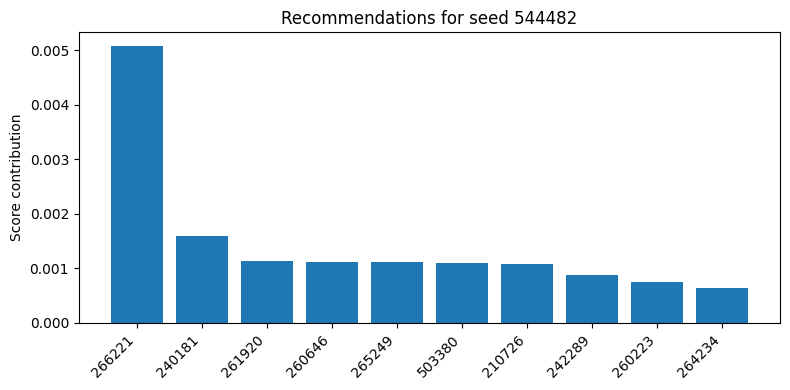

In [30]:
visualize_recs_for_single_item(seed_item=None, top_n=10)


?? Is the approach of Top-n precision evaluation. In this plan we’ll use all customers who have at least 10 product purchases, and measure the top-3 precision of recommendations using a 5-fold cross-validation against a random 80% training/20% test set. We measure as a “hit” anything withheld from the test set. We will identify the best few algorithm candidates based on highest top-3 precision. 